# Decoding mouse from session sequences


In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [3]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.cluster import KMeans
import random
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.inspection import permutation_importance

# --Machine learning and statistics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import entropy

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
# from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette

from one.api import ONE
one = ONE(mode='remote')

## Get sequences per trial epoch

In [4]:
seq_path = prefix + 'representation_learning_variability/paper-individuality/clustering/'
# all_sequences = pd.read_parquet(seq_path+'all_sequences_09-22-2025')
all_sequences = pd.read_parquet(seq_path+'all_sequences_09-29-2025')
# all_sequences = pd.read_parquet(seq_path+'all_sequences_11-19-2025')

In [5]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

In [16]:
del all_sequences

# Get data of interest for decoder

In [68]:
def prepare_mat(df, final_matrix):
    # Pseudo-random selection of one mouse per lab
    decoded_var = 'mouse_cluster'
    decoded_var = 'mouse_name'
    unique_labels = len(df[decoded_var].unique())  # 5?
    new_df = df.copy()
    
    mat = pd.DataFrame(final_matrix)
    mat['fact_var'] = pd.factorize(df[decoded_var])[0]
    mat[decoded_var] = new_df[decoded_var]

    use_labels = random.sample(list(mat['fact_var'].unique()), unique_labels)

    named_labels = mat.loc[mat['fact_var'].isin(use_labels), decoded_var].drop_duplicates()
    use_mat = mat.loc[mat['fact_var'].isin(use_labels)]
    use_mat = use_mat.drop(columns=[decoded_var])
    use_mat = use_mat.sort_values(by='fact_var')

        
    return use_mat, named_labels

In [56]:
use_mat, named_labels = prepare_mat(df, final_matrix, shuffle =False)

In [17]:
use_mat = pd.DataFrame(np.vstack(all_sequences['binned_sequence']))
use_mat['epoch'] = pd.factorize(all_sequences['broader_label'])[0]
named_labels = all_sequences['broader_label']

## Decode mouse

In [18]:
shufflings = 5  #shuffling
# model = RandomForestClassifier(max_depth=2, random_state=0)
model = RandomForestClassifier(random_state=42)
# model = MultinomialNB()
repeats = 5

var = 'epoch'

In [19]:
"""
RUN MODEL
"""

# Generate random states for each iteration with a fixed seed
# Loop over iterations of random draws of mice
# Create empty dataframes to save results
decoding_result = pd.DataFrame(columns=['shuffle', 'repeat', 'f1', 'confusion_matrix'])
dec_result = pd.DataFrame(columns=['shuffle', 'repeat', 'f1', 'confusion_matrix'])

# use_mat, named_labels = prepare_mat(df, final_matrix)

for r in range(repeats):
    print('Repeat %d of %d' % (r+1, repeats))  
    # Decoding function with 10-fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    # use_mat = mat.copy() # test using all mice

    # Find minimum number of samples per label
    labels = np.array(use_mat[var])
    labels_nr = np.arange(len(use_mat[var]))
    min_freq = np.min(use_mat[var].value_counts())
    # min_freq = 400

    # Randomly select N mice from each quartile to equalize classes
    use_index = np.empty(0, dtype=int)
    for j, epoch in enumerate(np.unique(labels)):
        use_index = np.concatenate([use_index, np.random.choice(labels_nr[labels == epoch],
                                                                min_freq, replace=False)])

    new_mat = use_mat.iloc[use_index].reset_index().drop(columns=['index']).copy()
            
    # -- ORIGINAL DATASET
    y_pred = np.zeros(len(new_mat), dtype=int) 
    exog = new_mat[new_mat.columns.difference([var])]
    endog = new_mat.loc[:, var].copy()

    for train_index, test_index in kf.split(new_mat):
        model.fit(exog.iloc[train_index], endog.iloc[train_index].astype(int))
        y_pred[test_index] = model.predict(exog.iloc[test_index])

    # Calculate f1 score and confusion matrix
    f1 = f1_score(endog.astype(int), y_pred.astype('int'), average='micro')
    cm = confusion_matrix(endog.astype(int), y_pred.astype('int'), normalize='true')

    # Save results
    dec_result.loc[0, 'f1'] = f1
    dec_result.loc[0, 'confusion_matrix'] = cm
    dec_result.loc[0, 'shuffle'] = 0
    dec_result.loc[0, 'repeat'] = r

    decoding_result = pd.concat([decoding_result, dec_result])

    # -- SHUFFLED DATASET 
    shuffle_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])
    for s in range(shufflings):
        if np.mod(s+1, 10) == 0:
            print('Shuffling %d of %d' % (s+1, shufflings))   

        shuffle_y_pred = np.zeros(len(new_mat), dtype=int) 
        shuffle_endog = endog.copy()
        np.random.shuffle(shuffle_endog.values)

        for train_index, test_index in kf.split(new_mat):
            model.fit(exog.iloc[train_index], list(shuffle_endog.iloc[train_index].astype(int)))
            shuffle_y_pred[test_index] = model.predict(exog.iloc[test_index])   

        shuffle_f1 = f1_score(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), average='micro')
        shuffle_cm = confusion_matrix(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), normalize='true')

        # SAVE
        shuffle_result.loc[s, 'f1'] = shuffle_f1
        shuffle_result.loc[s, 'confusion_matrix'] = shuffle_cm
        shuffle_result.loc[s, 'shuffle'] = s + 1

    decoding_result = pd.concat([decoding_result, shuffle_result])

Repeat 1 of 5


KeyboardInterrupt: 

In [20]:
decoding_result

,shuffle,repeat,f1,confusion_matrix
0,0,0,0.805169,"[[0.8882161710757851, 0.02101166154672075, 0.0..."


In [73]:
diagonal = pd.DataFrame(np.diag(decoding_result.loc[decoding_result['shuffle']==0, 'confusion_matrix'].mean()))
diagonal['mouse_number'] = list(named_labels.dropna())
diagonal = diagonal.rename(columns={0: 'accuracy'})

In [21]:
def plot_cm(decoding_result, trial_epochs, size, control=False):
    """
    PLOT RESULTS
    """

    # -- Confusion Matrix
    # labels = trial_epochs

    # Results on original model
    plt.rc('font', size=8) 
    plt.figure(figsize=size)
    # hmap = sns.color_palette("mako", as_cmap=True)
    hmap=plt.cm.get_cmap('Greys')
    data = decoding_result.loc[decoding_result['shuffle'] == 0]
    sns.heatmap(data['confusion_matrix'].mean(), annot=False, square=True,
        yticklabels=trial_epochs, xticklabels=trial_epochs, 
        cmap= hmap, vmin=0, vmax=1, fmt=".2f") 

    # plt.xticks([.5, 1.5, 2.5, 3.5], trial_epochs)
    # plt.yticks([.5, 1.5, 2.5, 3.5], trial_epochs)
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
    plt.xlabel('Predicted mouse')
    plt.ylabel('True mouse')
    # plt.savefig('full_cm.svg',dpi=500)
    plt.show()
    print('F1 results', data['f1'].mean())

    if control:
        # Results from shuffled model
        plt.rc('font', size=9) 
        plt.figure(figsize=size)
        data = decoding_result.loc[decoding_result['shuffle'] >0]
        sns.heatmap(data['confusion_matrix'].mean(), annot=False, square=True,
            yticklabels=trial_epochs, xticklabels=trial_epochs, 
            cmap= hmap, vmin=0, vmax=1, fmt=".2f")

        # plt.xticks([.5, 1.5, 2.5, 3.5], trial_epochs)
        # plt.yticks([.5, 1.5, 2.5, 3.5], trial_epochs)
        plt.xticks(rotation = 90)
        plt.yticks(rotation = 0)
        plt.xlabel('Predicted mouse')
        plt.ylabel('True mouse')
        plt.show()
        print('F1 shuffled results',  data['f1'].mean())
    plt.tight_layout()

In [22]:
from functions import create_grouped_gradient_palette, plot_cm, plot_f1


In [23]:
plot_cm(decoding_result, named_labels.dropna(), [14, 7], control=True)
plot_f1(decoding_result)
decoding_ratio = decoding_result.loc[decoding_result['shuffle']==0, 'f1']/decoding_result.loc[decoding_result['shuffle']==1, 'f1']
print(decoding_ratio)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fd730fe2050> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd70b67d120> (for post_execute):


KeyboardInterrupt: 

Text(0, 0.5, 'True labels')

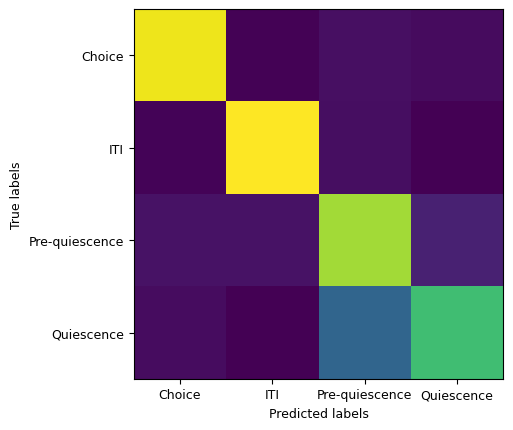

In [41]:
new_cm = np.concatenate([decoding_result['confusion_matrix'][0][2:, :], decoding_result['confusion_matrix'][0][:2, :]])
plt.imshow(decoding_result['confusion_matrix'][0])
plt.xticks([0, 1, 2, 3], ['Choice', 'ITI', 'Pre-quiescence', 'Quiescence'])
plt.yticks([0, 1, 2, 3], ['Choice', 'ITI', 'Pre-quiescence', 'Quiescence'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
